In [57]:
import torch
torch.cuda.is_available()

True

In [58]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Mon_Oct_12_20:09:46_PDT_2020
Cuda compilation tools, release 11.1, V11.1.105
Build cuda_11.1.TC455_06.29190527_0


In [59]:
! nvidia-smi

Thu Apr 21 05:38:52 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   48C    P0    28W /  70W |   5500MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [60]:
import numpy as np
from tqdm.notebook import tqdm
tqdm.pandas()
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
import glob
import shutil
import sys
#sys.path.append('../input/tensorflow-great-barrier-reef')
import torch
from PIL import Image

In [61]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [62]:
shutil.copy("/content/gdrive/MyDrive/tensorflow-great-barrier-reef/extra/__init__.py", "/content/__init__.py")
shutil.copy("/content/gdrive/MyDrive/tensorflow-great-barrier-reef/extra/coco.py", "/content/coco.py")
shutil.copy("/content/gdrive/MyDrive/tensorflow-great-barrier-reef/extra/utils.py", "/content/utils.py")
shutil.copy("/content/gdrive/MyDrive/tensorflow-great-barrier-reef/extra/version.py", "/content/version.py")

'/content/version.py'

In [63]:
!pwd

/content/gdrive/.shortcut-targets-by-id/1o8qX67ku1yk4X-LIcCUskGeDAefWaVpZ/tensorflow-great-barrier-reef/extra


In [64]:
from ut import coco2yolo, coco2voc, voc2yolo, voc2coco
from ut import draw_bboxes, load_image
from ut import clip_bbox, str2annot, annot2str

def predict(model, img, size=768, augment=False):
    height, width = img.shape[:2]
    results = model(img, size=size, augment=augment)  # custom inference size
    preds   = results.pandas().xyxy[0]
    bboxes  = preds[['xmin','ymin','xmax','ymax']].values
    if len(bboxes):
        bboxes  = voc2coco(bboxes,height,width).astype(int)
        confs   = preds.confidence.values
        return bboxes, confs
    else:
        return [],[]
    
def format_prediction(bboxes, confs):
    annot = ''
    if len(bboxes)>0:
        for idx in range(len(bboxes)):
            xmin, ymin, w, h = bboxes[idx]
            conf             = confs[idx]
            annot += f'{conf} {xmin} {ymin} {w} {h}'
            annot +=' '
        annot = annot.strip(' ')
    return annot

def show_img(img, bboxes, bbox_format='yolo'):
    names  = ['starfish']*len(bboxes)
    labels = [0]*len(bboxes)
    img    = draw_bboxes(img = img,
                           bboxes = bboxes, 
                           classes = names,
                           class_ids = labels,
                           class_name = True, 
                           colors = colors, 
                           bbox_format = bbox_format,
                           line_thickness = 2)
    return Image.fromarray(img).resize((800, 400))

In [65]:
ROOT_DIR  = '/content/gdrive/MyDrive/tensorflow-great-barrier-reef'
# CKPT_DIR  = '/kaggle/input/greatbarrierreef-yolov5-train-ds'
CKPT_PATH = '/content/gdrive/MyDrive/tensorflow-great-barrier-reef/reef_baseline_fold12/l6_3600_uflip_vm5_f12_up/f1/best.pt' # by @steamedsheep
IMG_SIZE  = 9000
CONF      = 0.25
IOU       = 0.40
AUGMENT   = True

In [66]:
# Train Data
df = pd.read_csv(f'{ROOT_DIR}/train.csv')
df['image_path'] = f'{ROOT_DIR}/train_images/video_'+df.video_id.astype(str)+'/'+df.video_frame.astype(str)+'.jpg'
df['annotations'] = df['annotations'].progress_apply(eval)
display(df.head(2))

  0%|          | 0/23501 [00:00<?, ?it/s]

video_id  sequence  video_frame  sequence_frame image_id annotations  \
0         0     40258            0               0      0-0          []   
1         0     40258            1               1      0-1          []   

                                          image_path  
0  /content/gdrive/MyDrive/tensorflow-great-barri...  
1  /content/gdrive/MyDrive/tensorflow-great-barri...

In [67]:
df['num_bbox'] = df['annotations'].progress_apply(lambda x: len(x))
data = (df.num_bbox>0).value_counts()/len(df)*100
print(f"No BBox: {data[0]:0.2f}% | With BBox: {data[1]:0.2f}%")

  0%|          | 0/23501 [00:00<?, ?it/s]

No BBox: 79.07% | With BBox: 20.93%


In [68]:
def get_bbox(annots):
    bboxes = [list(annot.values()) for annot in annots]
    return bboxes

def get_imgsize(row):
    row['width'], row['height'] = imagesize.get(row['image_path'])
    return row

np.random.seed(32)
colors = [(np.random.randint(255), np.random.randint(255), np.random.randint(255))\
          for idx in range(1)]

In [69]:
def load_model(ckpt_path, conf=0.25, iou=0.50):
    model = torch.hub.load('/content/gdrive/MyDrive/tensorflow-great-barrier-reef/yolov5-lib-ds',
                           'custom',
                           path=ckpt_path,
                           source='local',
                           force_reload=True)  # local repo
    model.conf = conf  # NMS confidence threshold
    model.iou  = iou  # NMS IoU threshold
    model.classes = None   # (optional list) filter by class, i.e. = [0, 15, 16] for persons, cats and dogs
    model.multi_label = False  # NMS multiple labels per box
    model.max_det = 1000  # maximum number of detections per image
    return model

In [70]:
pip install -r https://raw.githubusercontent.com/ultralytics/yolov5/master/requirements.txt

requirements: PyYAML>=5.3.1 not found and is required by YOLOv5, attempting auto-update...

requirements: 1 package updated per /content/gdrive/.shortcut-targets-by-id/1o8qX67ku1yk4X-LIcCUskGeDAefWaVpZ/tensorflow-great-barrier-reef/yolov5-lib-ds/requirements.txt
requirements: ⚠️ Restart runtime or rerun command for updates to take effect

YOLOv5 🚀 2022-2-5 torch 1.10.0+cu111 CUDA:0 (Tesla T4, 15110MiB)

Fusing layers... 
Model Summary: 280 layers, 12308200 parameters, 0 gradients, 16.2 GFLOPs
Adding AutoShape... 


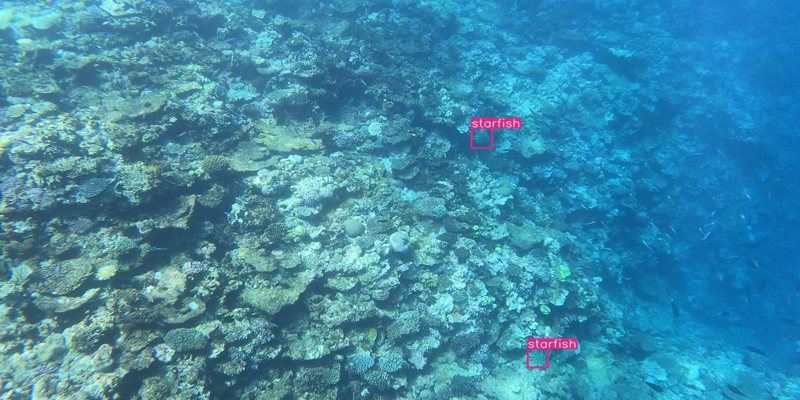

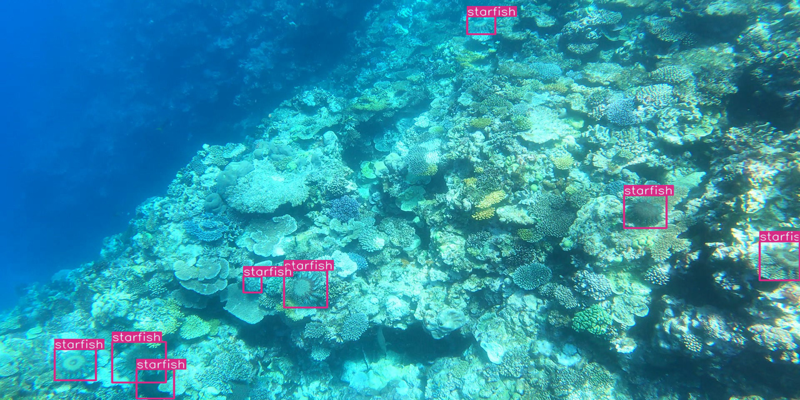

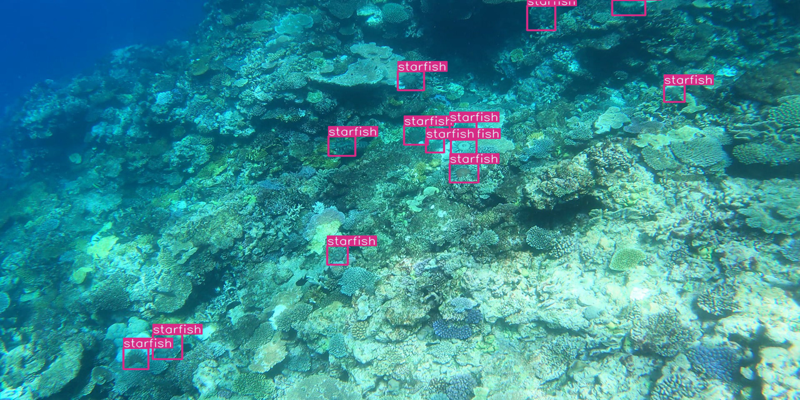

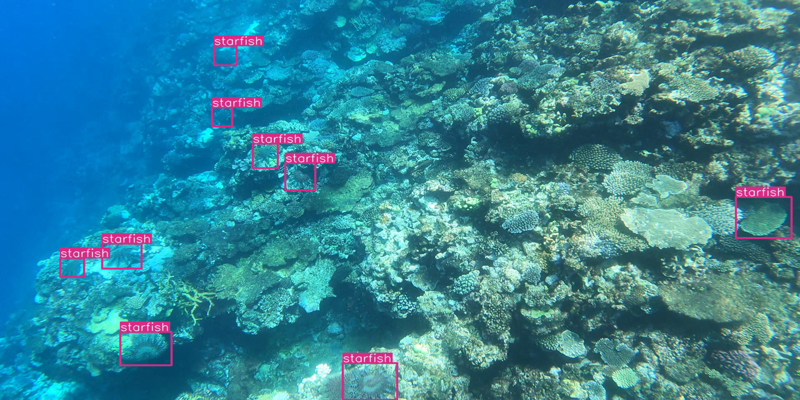

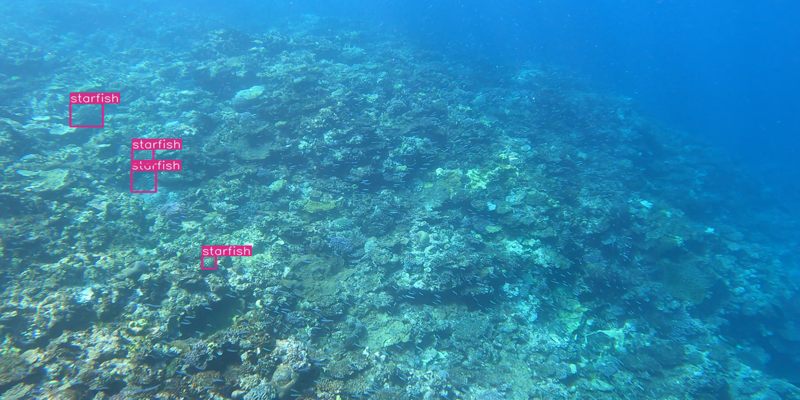

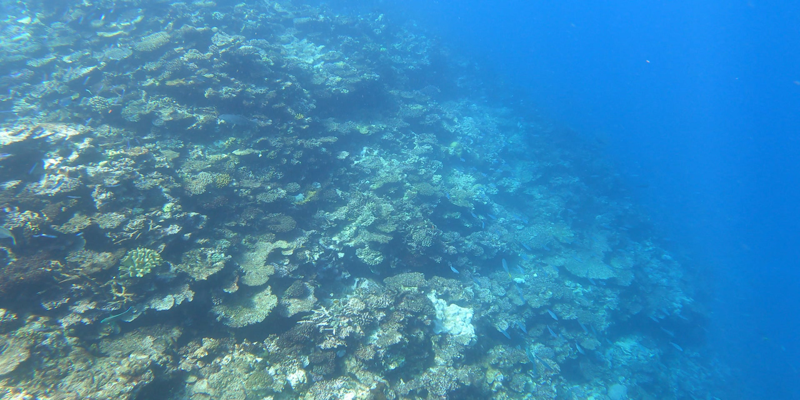

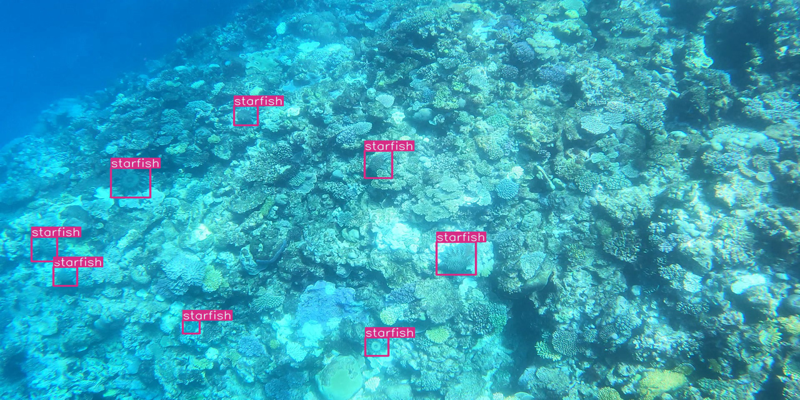

In [71]:
model = load_model(CKPT_PATH, conf=CONF, iou=IOU)
image_paths = df[df.num_bbox>1].sample(100).image_path.tolist()
for idx, path in enumerate(image_paths):
    img = cv2.imread(path)[...,::-1]
    bboxes, confis = predict(model, img, size=IMG_SIZE, augment=AUGMENT)
    display(show_img(img, bboxes, bbox_format='coco'))
    if idx>5:
        break